## Get the Data

- We will be using the Rotten Tomatoes movie reviews dataset.
- https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [3]:
### You need to accept the rules of the competition to download the data

In [4]:
pwd

'/Users/saramaras/Documents/github/NLP_Transformers_Python/code/project'

In [16]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./data')

    os.remove(f'{file}.zip')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.28M/1.28M [00:00<00:00, 2.33MB/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 494k/494k [00:00<00:00, 5.19MB/s]

# Prepare the  Data


In [77]:
import pandas as pd

In [78]:
df = pd.read_csv('data/train.tsv', sep='\t')

In [79]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


- Reamove the duplicates

In [80]:
#df = df.drop_duplicates(subset=['SentenceId'], keep='first')

In [81]:
df.shape

(156060, 4)

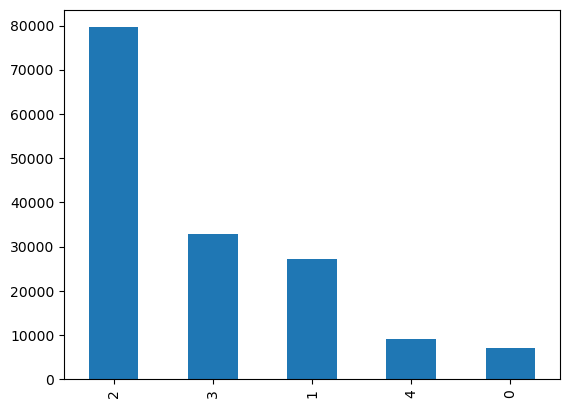

In [82]:
df['Sentiment'].value_counts().plot(kind='bar');

We will be tokenizing this text to create two input tensors; our input IDs, and attention mask.

We will contain our tensors within two numpy arrays, which will be of dimensions len(df) * 512 - the 512 is the sequence length of our tokenized sequences for BERT, and len(df) the number of samples in our dataset.



In [83]:
import numpy as np

seq_len = 512
num_samples = len(df)

In [84]:
num_samples, seq_len

(156060, 512)

In [85]:
# Begin the tokenization with a BertTokenizer, like so:

In [86]:
phrase_list=df['Phrase'].tolist()
phrase_list

['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'A series of escapades demonstrating the adage that what is good for the goose',
 'A series',
 'A',
 'series',
 'of escapades demonstrating the adage that what is good for the goose',
 'of',
 'escapades demonstrating the adage that what is good for the goose',
 'escapades',
 'demonstrating the adage that what is good for the goose',
 'demonstrating the adage',
 'demonstrating',
 'the adage',
 'the',
 'adage',
 'that what is good for the goose',
 'that',
 'what is good for the goose',
 'what',
 'is good for the goose',
 'is',
 'good for the goose',
 'good',
 'for the goose',
 'for',
 'the goose',
 'goose',
 'is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
 'is also good for the gander , some of which occasionally amuses but none of 

In [87]:
from transformers import BertTokenizer

#initialize the tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

#tokenize - gonna return numpy tensors

tokens = tokenizer(phrase_list, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True,
                  return_tensors='np')

In [88]:
import tensorflow as tf

In [89]:
tf.__version__

'2.11.0'

In [90]:
tokens.values()

dict_values([array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])])

In [91]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [92]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [93]:
# saving them as a numpy binary files

with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

- Now that we have them on file, we can delete the in-memory arrays to free up memory.

In [94]:
del tokens

Our input tensors are prepared, but we haven't touched our target data yet. So, let's move onto that.

Presently our target data is a set of integer values (representing sentiment classes) in the Sentiment column of our dataframe df. We need to extract these values and one-hot encode them into another numpy array, which will have the dimensions len(df) * number of label classes. Again, we will initialize a numpy zero array beforehand, but we won't populate it row by row - we will use some fancy indexing techniques instead.

In [95]:
# first extract sentiment column

arr = df['Sentiment'].values
np.unique(arr)

array([0, 1, 2, 3, 4])

In [96]:
arr.max()+1

5

In [97]:
# then initialize the zero array
labels = np.zeros((num_samples,arr.max()+1))
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

We are able to use arr.max()+1 to define our second dimension here because we have the values [0, 1, 2, 3, 4] in our Sentiment column, there are five unique labels which means we need our labels array to have five columns (one for each) - arr.max() = 4, so we do 4 + 1 to get our required value of 5.

Now we use the current values in our arr of [0, 1, 2, 3, 4] to place 1 values in the correct positions of our presently zeros-only array:

In [98]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

And there is our one-hot encoded labels array. Just like before, we save this to file as a Numpy binary file.

In [99]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

---------------------------------------